In [ ]:
!pip install colab_ssh --upgrade --quiet
from colab_ssh import launch_ssh_cloudflared, init_git_cloudflared
launch_ssh_cloudflared(password='12', verbose=True, kill_other_processes=True)

DEBUG: Cloudflared process: PID=1588
DEBUG: Exception: Cannot get any result from cloudflared metrics
DEBUG: Killing 1588. Retrying...
DEBUG: Cloudflared process: PID=1595
DEBUG: {'domain': 'master-justin-stages-kids.trycloudflare.com', 'protocol': '', 'port': 22}


In [ ]:
init_git_cloudflared("https://github.com/TINGWEIJING/Tensorflow.git",
         personal_token="", 
         branch="main",
         email="",
         username="")

Successfully cloned the repository in ./Tensorflow


In [2]:
import sys
sys.executable

'/usr/bin/python3'

In [1]:
!nvidia-smi

Wed Jun  1 12:34:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!echo $HOME 
!pwd

/root
/content


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
!cp '/content/drive/MyDrive/Shared 01/mobilenetv3-ic/datasets/face_mask_datasets.zip' '/content/'

In [8]:
!unzip -q '/content/face_mask_datasets.zip' -d '/content/face_mask_datasets/'

## MobileNetv3

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from tensorflow.keras import layers

In [3]:
builder = tfds.folder_dataset.ImageFolder('/content/face_mask_datasets/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
# raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=58394,
    splits={
        'test': 4782,
        'train': 53612,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



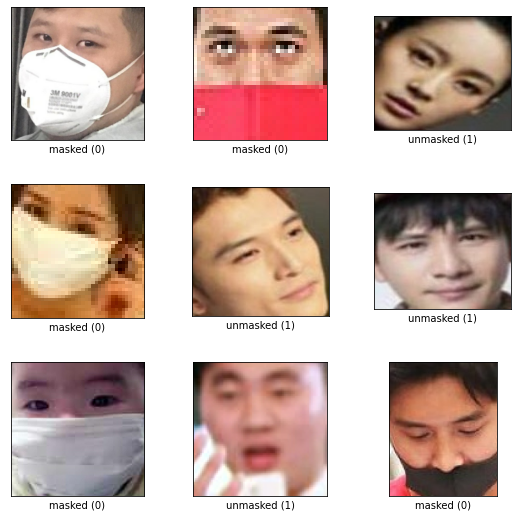

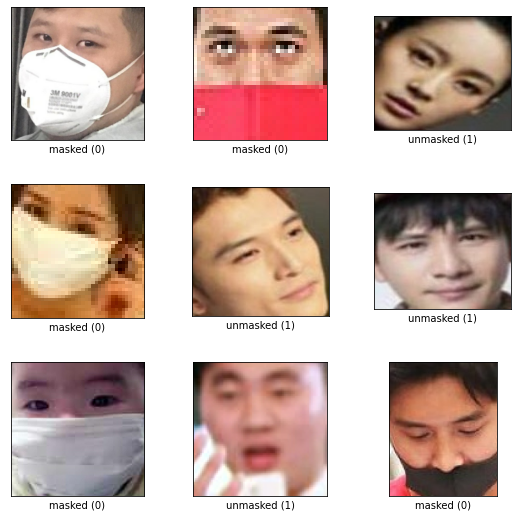

In [65]:
tfds.show_examples(raw_train, builder.info)

In [8]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.1, seed=42),
  layers.RandomTranslation(height_factor=0.1, width_factor=0.1, seed=42),
])


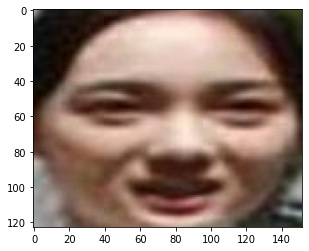

In [5]:
raw_sample = next(iter(raw_train))
image = raw_sample['image']
label = raw_sample['label']
_ = plt.imshow(image)


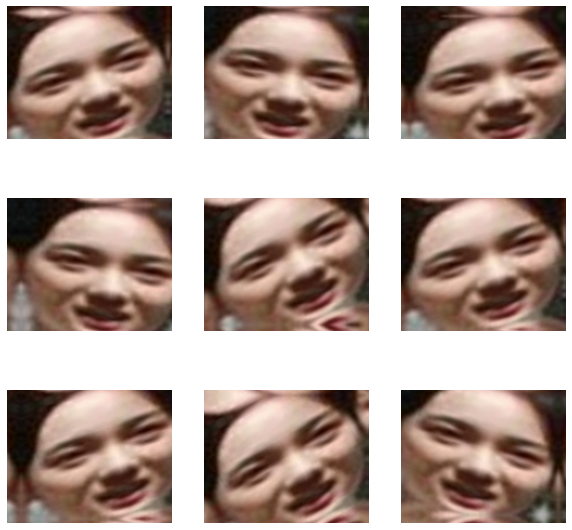

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  augmented_image = tf.cast(augmented_image, tf.uint8)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)
  plt.axis("off")


In [10]:
# format image size
IMG_SIZE = 224 # mobilenetv3small uses 224, 224

def preprocess_image(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

def aug_preprocess_image(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = data_augmentation(image) # data augmentation
  return image, label

In [11]:
train = raw_train.map(aug_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test = raw_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [13]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [14]:
# inspect batch data
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [15]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

In [16]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 576)


In [17]:
# feature extraction & freeze conv base
base_model.trainable = False

In [18]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 576)


In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [21]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 577       
                                                                 
Total params: 939,697
Trainable params: 577
Non-trainable params: 939,120
_________________________________________________________________


In [24]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(test_batches, steps = validation_steps)

20/20 [==============================] - 3s 38ms/step - loss: 0.8456 - accuracy: 0.4547


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.85
initial accuracy: 0.45


In [27]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=test_batches)

Epoch 1/20
1676/1676 [==============================] - 443s 258ms/step - loss: 0.2591 - accuracy: 0.8774 - val_loss: 0.3349 - val_accuracy: 0.8266
Epoch 2/20
1676/1676 [==============================] - 426s 250ms/step - loss: 0.0907 - accuracy: 0.9724 - val_loss: 0.3329 - val_accuracy: 0.8427
Epoch 3/20
1676/1676 [==============================] - 427s 251ms/step - loss: 0.0725 - accuracy: 0.9770 - val_loss: 0.3272 - val_accuracy: 0.8517
Epoch 4/20
1676/1676 [==============================] - 429s 252ms/step - loss: 0.0658 - accuracy: 0.9782 - val_loss: 0.3428 - val_accuracy: 0.8507
Epoch 5/20
1676/1676 [==============================] - 426s 250ms/step - loss: 0.0613 - accuracy: 0.9793 - val_loss: 0.3526 - val_accuracy: 0.8524
Epoch 6/20
1676/1676 [==============================] - 428s 251ms/step - loss: 0.0579 - accuracy: 0.9801 - val_loss: 0.3464 - val_accuracy: 0.8578
Epoch 7/20
1676/1676 [==============================] - 424s 249ms/step - loss: 0.0564 - accuracy: 0.9809 - val_

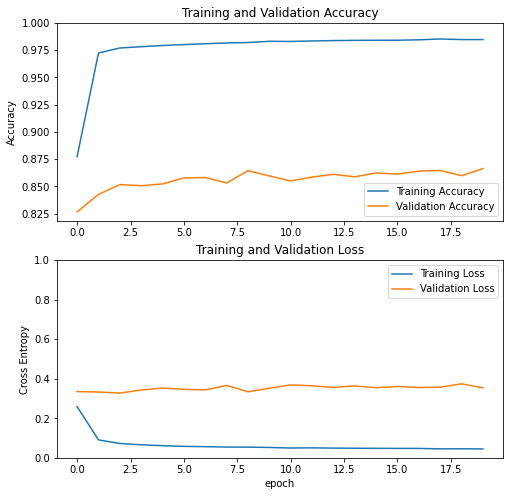

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [31]:
for test_sample in test_batches.take(10):  
  image, label = test_sample[0], test_sample[1]
   

  img = tf.keras.preprocessing.image.img_to_array(tf.squeeze(image))
  
  make_predictions=model.predict(image)

  label_name = "unmasked" if label == 1 else "masked"
  pred_label = "unmasked" if make_predictions > 0 else "masked"
  print(make_predictions)
  plt.figure()
  plt.imshow(img.astype(np.uint8))
  plt.show()
  print("Actual Label: %s" % label_name)
  print("Predicted Label: %s" % pred_label)

ValueError: ignored

In [38]:
_parent_path = ''
_owner_path = '/content/drive/MyDrive/Shared 01/mobilenetv3-ic'
_shared_path = '/content/drive/MyDrive/mobilenetv3-ic'
if Path(_owner_path).exists():
    _parent_path = Path(_owner_path)
else:
    _parent_path = Path(_shared_path)

timestamp = datetime.today().strftime("%y%m%d%H%M")
export_path = _parent_path / "saved_models" / f"{timestamp}_mobilenetv3small"
export_path.parent.mkdir(exist_ok = True)

# model.save(export_path)

In [44]:
timestamp = 2206011533
export_path = _parent_path / "saved_models" / f"{timestamp}_mobilenetv3small"
zip_path = _parent_path / "saved_models" / f"{timestamp}_mobilenetv3small.zip"
export_path_str = f'"{str(export_path)}"'
zip_path_str = f'"{str(zip_path)}"'
print(export_path_str)
print(zip_path_str)
# !zip -r {export_path} {export_path}

"/content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small"
"/content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small.zip"


In [46]:
!zip -r "/content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small" "/content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small"

  adding: content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small/ (stored 0%)
  adding: content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small/variables/ (stored 0%)
  adding: content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small/variables/variables.index (deflated 72%)
  adding: content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small/assets/ (stored 0%)
  adding: content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small/saved_model.pb (deflated 91%)
  adding: content/drive/MyDrive/Shared 01/mobilenetv3-ic/saved_models/2206011533_mobilenetv3small/keras_metadata.pb (deflated 95%)
